In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [ ]:
reload(hp)

with open('../data/converted/amazon-walmart/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [ ]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        dropout=0.5,
                        batch_norm=True,
                        lstm_args=dict(units=25, dropout=0, recurrent_dropout=0),
                        shared_lstm=True)

# Crash recovery 

In [4]:
model.load_weights('../data/models/amazon-walmart-base-2-full')
df_hist = pd.read_csv('../data/histories/amazon-walmart-base-2-full.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=4096,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 140s 2ms/step - loss: 0.0099 - acc: 0.9980 - val_loss: 0.0325 - val_acc: 0.9961


# Learning curves

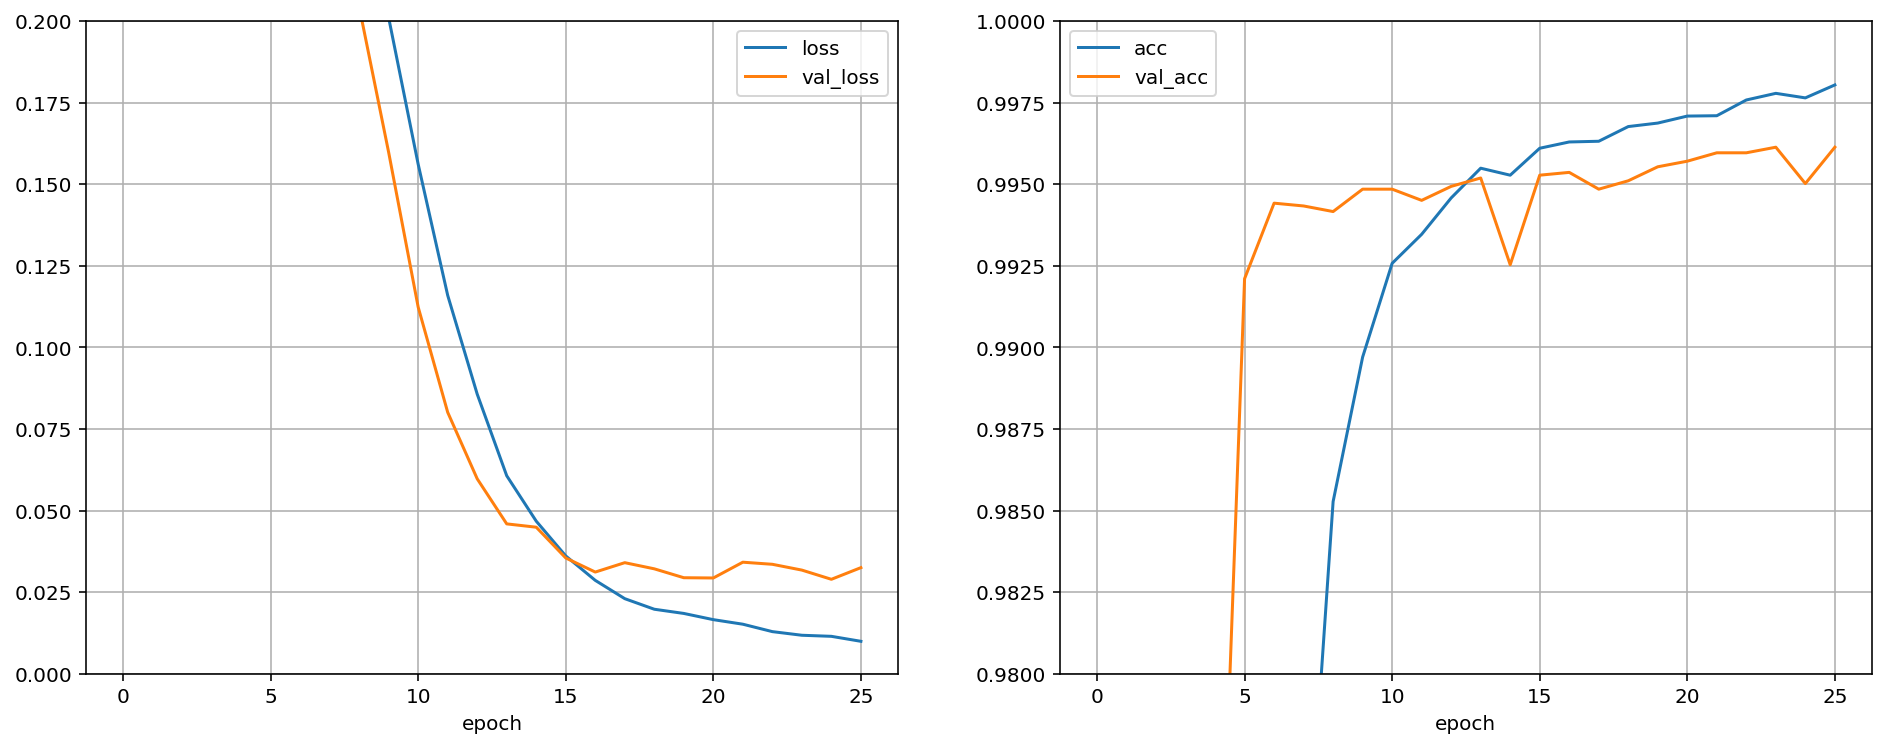

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set(ylim = (0, 0.2))
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set(ylim = (0.98, 1))

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [33]:
y_val_pred = model.predict(X_val, batch_size=4096)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11525
          1       0.82      0.85      0.83       131

avg / total       1.00      1.00      1.00     11656

[[11500    25]
 [   20   111]]


In [86]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(10)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
9045,21813,,projector accessories,portable rental deluxe screen skirt adapter clamp,6.99,skirt adapter brackets to allow use of larger skirt on smaller width,nan,skirt adapter brackets allow larger skirts to be attached to smaller width,0.0,0.0,...,electronics general,deluxe skirt adapter bracket for fast fold screens,6.99,deluxe skirt adapter allows for use of larger skirt on smaller width deluxe fast fold price is per,nan,dl1633deluxe skirt adapter allows for use of larger skirt on smaller width deluxe fast fold price is per,0.500,0.00,0.00,0.00
4332,4494,norazza,accessories,ape case small digital camera bag ac165,15.99,inner pockets for holding media batteries and other accessories external easy access mesh pockets padded and water resistant convenient belt loop and removable shoulder strap signature yellow interior makes finding your equipment easier external inner pockets for holding media batteries amp other accessories mesh pockets zippered pouch amp pocket keeps contents safe,nan,ape case small digital camera bag ac165 this case offers little extra space for standard sized digital with four inner pockets it great for holding media batteries and other the external easy to access mesh pockets and zippered pouch and pocket keeps contents the bag conveniently attaches to your belt and has removable shoulder it has extra padding water resistant and has the signature yellow ac160 ac165 ac220 ac240 ac250 ac252 ac260 ac120 ac145 ac150 inner pockets great for holding media batteries and other offers little extra space for standard sized digital designed to hold your digital camera and much front pocket holds batteries media cards and other front pocket holds batteries media cards and many other front pocket holds batteries media cards and many other folds out to multi pocket wallet with plenty of room for credit cards passport digital media cards money traveler checks maps pda and large front pocket holds large variety of accessories including c...,0.0,8.0,...,photography general,ape case ac165 digital camera case,12.85,keep your digital camera safe from life hard knocks with theac165 ape case for digital cameras by norazza,the ac165 ape case for digital cameras is case designed to hold your digital camera and much,key features benefits extra space offers little extra space for standard sized digital cameras four inner pockets great for holding media batteries and other accessories construction keeps the elements away from your valuable camera signature bright yellow interior makes it easy to see everything stowed inside two external mesh pockets easily access instructions gum pens and your other necessities two carrying options attaches to your belt and has removeable shoulder strap inner dimensions outer dimensions,0.810,8.00,5.00,3.50
10388,6873,iris,computers accessories,iris usoa400 irispen express pen scanner,129.99,portable scanner with ocr recognizes 128 languages recognizes alphanumeric characters numeric data mathematical symbols currency symbols and much more scans small images scans up to inches per second mac and pc compatible powers off usb port automatically recognizes mix of western and greek or cyrillic languages optionally reads japanese simplified chinese traditional chinese and korean,irispen express pen scanner,product description the iris usoa400 irispen express pen scanner is portable scanner that works just like you simply slide the scanner over virtually any printed text and the text is automatically scanned directly into your ideal for remote research projects or any task in which flatbed scanner would prove too cumbersome this scanner operates at rate of over three inches per second and recognizes 128 the iris usoa400 irispen express pen scanner offers small size for easy automatic conversion of text on paper into editable text on t

# Save model and histories 

In [34]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-base-2-full.csv', index=False)
model.save_weights('../data/models/amazon-walmart-base-2-full')

# Test model 

In [35]:
model.load_weights('../data/models/amazon-walmart-base-2-full')
y_test_pred = model.predict(X_test, batch_size=4096)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11540
          1       0.89      0.79      0.84       115

avg / total       1.00      1.00      1.00     11655

[[11529    11]
 [   24    91]]
